In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from statistics import mode
import line_profiler


In [ ]:
fish = pd.read_csv('fish1.txt', sep= ' ',header=None)
# fish = fish.reset_index().iloc[:,1:]
fish.columns = ['X','Y','Z']
print(fish.describe())
print(fish.skew())
print(fish.kurtosis())

def IQR(dist):
    return np.percentile(dist, 75) - np.percentile(dist, 25)
# IQR(fish_all.X)

def data_preprocess(df, bait):
    df = df[df.Z == bait]
    df = df.sort_values('X')
    df['T'] = df['X'].diff()
    df.iloc[0,-1] = df.iloc[0,0]
    df = df.reset_index().drop('index',axis=1)
    return df

def deal_with_zero_t(df):
    for k,row in df.iterrows():
        if row['T'] == 0:
            df.iloc[k,3] =df.iloc[k-1,3]
    return df
    
fish_A = data_preprocess(fish, 'A')
fish_A = deal_with_zero_t(fish_A)
fish_B = data_preprocess(fish, 'B')
fish_B = deal_with_zero_t(fish_B)
fish_C = data_preprocess(fish, 'C')
fish_C = deal_with_zero_t(fish_C)
fish_all = fish_A.append(fish_B).append(fish_C)
fish_all.head()

                X          Y
count  400.000000  400.00000
mean     9.370525    1.66740
std      5.796400    1.10816
min      0.010000    0.01000
25%      4.325000    0.70750
50%      9.020000    1.61500
75%     13.747500    2.40000
max     22.270000    4.88000
X    0.266856
Y    0.653793
dtype: float64
X   -0.946594
Y    0.161891
dtype: float64


,X,Y,Z,T
0,0.26,2.54,A,0.26
1,0.39,1.85,A,0.13
2,0.55,0.19,A,0.16
3,0.65,2.26,A,0.10
4,0.78,0.99,A,0.13


In [ ]:
print('A',fish_A.mean())
print('B',fish_B.mean())
print('C',fish_C.mean())

A X    5.849747
Y    1.528987
T    0.272278
dtype: float64
B X    10.384219
Y     1.783750
T     0.327813
dtype: float64
C X    10.200350
Y     1.680973
T     0.099183
dtype: float64


## 1.1. generate a plot that illustrates the distributions of X values (times of catch, the format is hours, fraction of hours on a 24h schedule for the day)

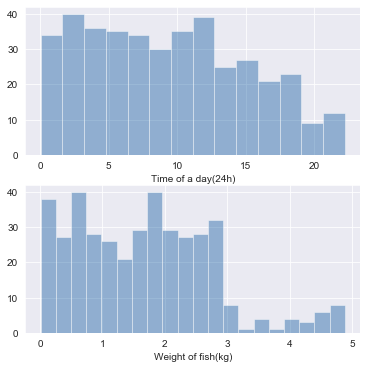

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(6,6))
sns.set_style("darkgrid")
sns.set_palette("Blues_r")
sns.distplot(fish['X'], hist = True,kde=False, axlabel="Time of a day(24h)", bins=int((fish_all['X'].max()-fish_all['X'].min())/2*IQR(fish_all['X'])/(len(fish_all)**(1/3))), ax=ax[0])
sns.distplot(fish['Y'], hist = True,kde=False, axlabel="Weight of fish(kg)", bins=int(1+3.322*np.log(len(fish))), ax=ax[1])
plt.savefig("Distributions_of_Y_and_Y.png")


In [ ]:
len(fish_all)**(1/3)

7.368062997280773

## 1.2. plot the distribution of Y values (size of catch),

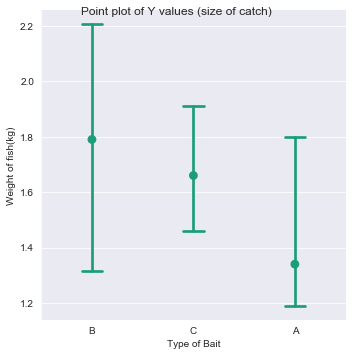

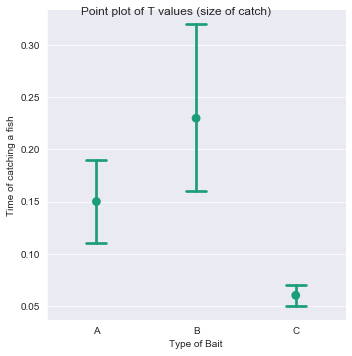

In [ ]:
g2=sns.catplot(x="Z", y='Y', data=fish, kind="point", join=False, estimator=np.median, capsize=0.2)
g2.fig.suptitle("Point plot of Y values (size of catch)")
g2.set(xlabel="Type of Bait",
       ylabel="Weight of fish(kg)")
g3=sns.catplot(x="Z", y='T', data=fish_all, kind="point", join=False, estimator=np.median, capsize=0.2)# median is more robust to outliers
g3.fig.suptitle("Point plot of T values (size of catch)")
g3.set(xlabel="Type of Bait",
       ylabel="Time of catching a fish")

## 1.3. generate a plot which analyses the effectiveness of each type of bait

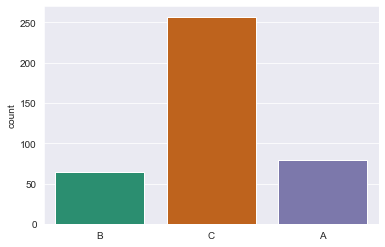

In [ ]:
# rods C catches the most fishes
sns.set_palette('Dark2')
sns.countplot(fish['Z'].values)
plt.savefig("Count_plot_of_Z.png")

In [ ]:
# Way to measures effectiveness: Y/T

print((fish_A['Y']/fish_A['T']).mean())
print((fish_B['Y']/fish_B['T']).mean())
print((fish_C['Y']/fish_C['T']).mean())
efficency = pd.DataFrame({'Efficiency':[(fish_A['Y']/fish_A['T']).mean(),(fish_B['Y']/fish_B['T']).mean(),(fish_C['Y']/fish_C['T']).mean()], 
                           'Bait':['A','B','C']})
efficency



23.4977432283046
17.850556115892108
47.25848082874183


,Efficiency,Bait
0,23.497743,A
1,17.850556,B
2,47.258481,C


/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning:

Second argument 'B' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning:

Second argument 'C' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning:

Second argument 'B' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning:

Second argument 'C' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry i

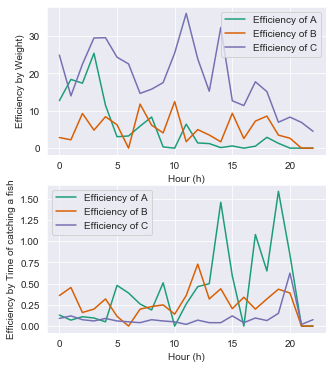

In [ ]:
def calculate_bait_efficiency_by_hour(fish, bait=None, metric = None):
    if metric == 'time':
        if bait == None:
            efficiency = []
            for i in range(1,24):
                time = []
                num = 0
                for j in range(len(fish)):
                    if i-1 <= fish.iloc[j,0] < i:
                        time.append(1*fish.iloc[j,3])
                        num+=1
                    else:
                        continue
                if num != 0:
                    efficiency.append(np.median(time))
                else:
                    efficiency.append(0)
        elif bait == 'A':
            efficiency = []
            for i in range(1,24):
                time = []
                num = 0
                for j in range(len(fish_A)):
                    if i-1 <= fish_A.iloc[j,0] < i:
                        time.append(1*fish_A.iloc[j,3])
                        num+=1
                    else:
                        continue
                if num != 0:
                    efficiency.append(np.median(time))
                else:
                    efficiency.append(0)
        elif bait == 'B':
            efficiency = []
            for i in range(1,24):
                time = []
                num = 0
                for j in range(len(fish_B)):
                    if i-1 <= fish_B.iloc[j,0] < i:
                        time.append(1*fish_B.iloc[j,3])
                        num+=1
                    else:
                        continue
                if num != 0:
                    efficiency.append(np.median(time))
                else:
                    efficiency.append(0)
        else:
            efficiency = []
            for i in range(1,24):
                time = []
                num = 0
                for j in range(len(fish_C)):
                    if i-1 <= fish_C.iloc[j,0] < i:
                        time.append(1*fish_C.iloc[j,3])
                        num+=1
                    else:
                        continue
                if num != 0:
                    efficiency.append(np.median(time))
                else:
                    efficiency.append(0)
    if metric == 'weight':
        if bait == None:
            efficiency = []
            for i in range(1,24):
                weight=0
                num = 0
                for j in range(len(fish_B)):
                    if i-1 <= fish.iloc[j,0] < i:
                        weight+=1*fish.iloc[j,1]
                        num+=1
                    else:
                        continue
                if num != 0:
                    efficiency.append(weight)
                else:
                    efficiency.append(0)
        elif bait == 'A':
            efficiency = []
            for i in range(1,24):
                weight=0
                num = 0
                for j in range(len(fish_A)):
                    if i-1 <= fish_A.iloc[j,0] < i:
                        weight+=1*fish_A.iloc[j,1]
                        num+=1
                    else:
                        continue
                if num != 0:
                    efficiency.append(weight)
                else:
                    efficiency.append(0)
        elif bait == 'B':
            efficiency = []
            for i in range(1,24):
                weight=0
                num = 0
                for j in range(len(fish_B)):
                    if i-1 <= fish_B.iloc[j,0] < i:
                        weight+=1*fish_B.iloc[j,1]
                        num+=1
                    else:
                        continue
                if num != 0:
                    efficiency.append(weight)
                else:
                    efficiency.append(0)
        else:
            efficiency = []
            for i in range(1,24):
                weight=0
                num = 0
                for j in range(len(fish_C)):
                    if i-1 <= fish_C.iloc[j,0] < i:
                        weight+=1*fish_C.iloc[j,1]
                        num+=1
                    else:
                        continue
                if num != 0:
                    efficiency.append(weight)
                else:
                    efficiency.append(0)
    return efficiency

efficiency_A = calculate_bait_efficiency_by_hour(fish_all, bait='A', metric='weight')
efficiency_B = calculate_bait_efficiency_by_hour(fish_all, bait='B', metric='weight')
efficiency_C = calculate_bait_efficiency_by_hour(fish_all, bait='C', metric='weight')
efficiency_all = calculate_bait_efficiency_by_hour(fish_all, metric='weight')
efficiency = pd.DataFrame({'A':efficiency_A,'B':efficiency_B,'C':efficiency_C, 'All':efficiency_all})
efficiency = efficiency.reset_index()
efficiency.head()
sns.set_palette('Dark2')
fig,ax = plt.subplots(2,1,figsize=(5,6))
ax[0].plot('index','A',data=efficiency, label='Efficiency of A')
ax[0].plot('index','B',data=efficiency, label='Efficiency of B')
ax[0].plot('index','C',data=efficiency, label='Efficiency of C')
ax[0].set_xlabel('Hour (h)')
ax[0].set_ylabel("Efficiency by Weight)")
ax[0].legend()
# plt.savefig("Efficiecy_Of_Each_Bait_By_Weight.png")

efficiency_A = calculate_bait_efficiency_by_hour(fish_all, bait='A', metric='time')
efficiency_B = calculate_bait_efficiency_by_hour(fish_all, bait='B', metric='time')
efficiency_C = calculate_bait_efficiency_by_hour(fish_all, bait='C', metric='time')
efficiency_all = calculate_bait_efficiency_by_hour(fish_all, metric='time')
efficiency_time = pd.DataFrame({'A':efficiency_A,'B':efficiency_B,'C':efficiency_C, 'All':efficiency_all})
efficiency_time = efficiency_time.reset_index()
efficiency_time.head()
sns.set_palette('Dark2')
ax[1].plot('index','A',data=efficiency_time, label='Efficiency of A')
ax[1].plot('index','B',data=efficiency_time, label='Efficiency of B')
ax[1].plot('index','C',data=efficiency_time, label='Efficiency of C')
ax[1].set_xlabel('Hour (h)')
ax[1].set_ylabel("Efficiency by Time of catching a fish")
ax[1].legend()
plt.savefig("Efficiecy_Of_Each_Bait_By_Weight_And_Time.png")

## 1.4. Characterise and describe these distributions by measures of centrality, spread, and suitable additional measures introduced in the introduction to statistics lectures that you think shed light on the shape of the respective distributions

In [ ]:
fish_all.groupby('Z').median()

,X,Y,T
Z,,,
A,3.57,1.34,0.15
B,10.24,1.79,0.23
C,10.49,1.66,0.06


In [ ]:
fish_ = np.log(fish_all['X'])

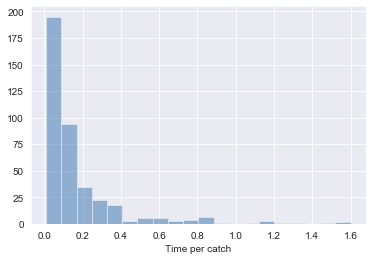

In [ ]:
sns.set_style("darkgrid")
sns.set_palette("Blues_r")
sns.distplot(fish_all['T'], hist = True,kde=False, axlabel="Time per catch", bins=int(1+3.322*np.log(len(fish_all))))

plt.savefig("DistributionOfT.png")

## 1.5. Assuming that the data are a sample from a larger population, give mean values with 95% confidence intervals for both distributions.

In [ ]:
def calculate_confidence_interval(data, confidence = 0.95):
    data = np.array(data)
    n = len(data)
    m, sem = np.mean(data), scipy.stats.sem(data)
    h = sem*scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
print("all kinds of baits:")
m, l, r = calculate_confidence_interval(fish['X'].values)
print(m)
print("The 95% confidence interval of X is [",l,",",r,"]")
m, l, r = calculate_confidence_interval(fish['Y'].values)
print(m)
print("The 95% confidence interval of Y is [",l,",",r,"]")

print("bait A:")
m, l, r = calculate_confidence_interval(fish_A['X'].values)
print(m)
print("The 95% confidence interval of X is [",l,",",r,"]")
m, l, r = calculate_confidence_interval(fish_A['Y'].values)
print(m)
print("The 95% confidence interval of Y is [",l,",",r,"]")

print("bait B:")
m, l, r = calculate_confidence_interval(fish_B['X'].values)
print(m)
print("The 95% confidence interval of X is [",l,",",r,"]")
m, l, r = calculate_confidence_interval(fish_B['Y'].values)
print(m)
print("The 95% confidence interval of Y is [",l,",",r,"]")

print("bait C:")
m, l, r = calculate_confidence_interval(fish_C['X'].values)
print(m)
print("The 95% confidence interval of X is [",l,",",r,"]")
m, l, r = calculate_confidence_interval(fish_C['Y'].values)
print(m)
print("The 95% confidence interval of Y is [",l,",",r,"]")

all kinds of baits:
9.370525
The 95% confidence interval of X is [ 8.800759907346904 , 9.940290092653097 ]
1.6674
The 95% confidence interval of Y is [ 1.5584719359190635 , 1.7763280640809365 ]
bait A:
5.849746835443038
The 95% confidence interval of X is [ 4.674332901651217 , 7.0251607692348585 ]
1.5289873417721522
The 95% confidence interval of Y is [ 1.3022128433869817 , 1.7557618401573227 ]
bait B:
10.38421875
The 95% confidence interval of X is [ 8.95966293182125 , 11.808774568178752 ]
1.7837500000000002
The 95% confidence interval of Y is [ 1.5143695279681002 , 2.0531304720319 ]
bait C:
10.200350194552529
The 95% confidence interval of X is [ 9.514223733361755 , 10.886476655743303 ]
1.6809727626459143
The 95% confidence interval of Y is [ 1.5405918896297786 , 1.82135363566205 ]


## 2.1. analyse the dependence between time of catch (X value) , size of catch (Y value), and the type of bait used (Z). Generate suitable plots to analyze these relationships and characterize them by statistical measures.

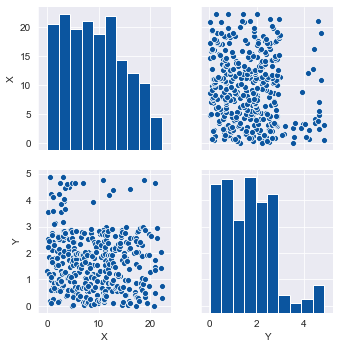

In [ ]:
sns.pairplot(fish_all[['X','Y']])

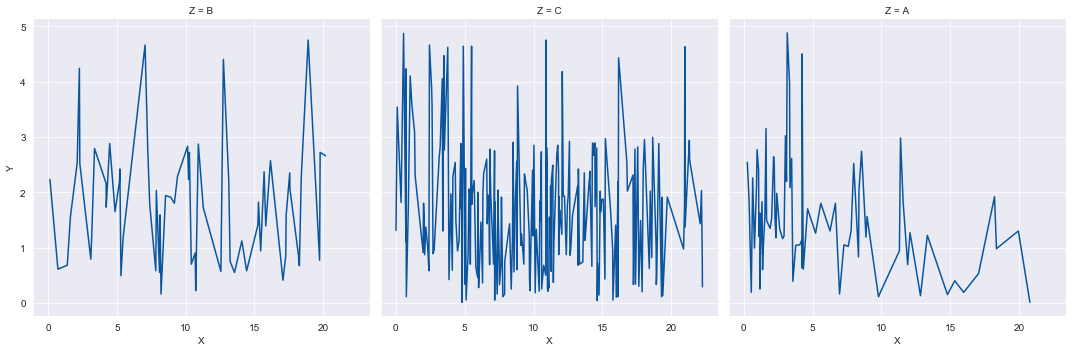

In [ ]:
sns.relplot(x="X", y="Y", data=fish, col='Z', kind="line", ci=None)
plt.show()

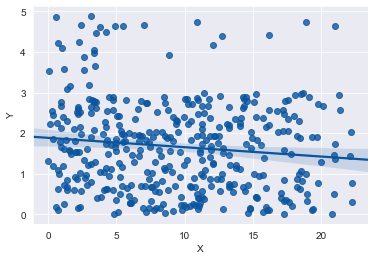

In [ ]:
sns.set_style("darkgrid")
sns.set_palette("Blues_r")
sns.regplot(x="X", y="Y", data=fish_all)
plt.savefig('Scatter_plot_of_X_Y.png')

In [ ]:
from scipy import stats
# Use the pearsonr method to find the correlation details 
# Is it positive or negative?
# Is it statistically significant?
r = stats.pearsonr(fish_all["X"],fish_all["Y"])[0]
n = len(fish_all)
t = (r*np.sqrt(n-2))/np.sqrt(1-r**2)
print(t)

-2.423509252127911


Text(0.5, 0, 'X of Bait C')

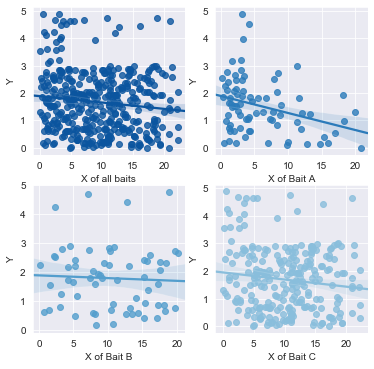

In [ ]:
def r2(x,y):
    return stats.pearsonr(x,y)[0]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6,6))
sns.set_style("darkgrid")
sns.set_palette("Blues_r")
sns.regplot(x="X", y="Y", data=fish_all, ax=ax[0][0], label='all')
ax[0][0].set_xlabel('X of all baits')
sns.regplot(x="X", y="Y", data=fish_all[fish_all['Z']=='A'], ax=ax[0][1], label='Bait A')
ax[0][1].set_xlabel('X of Bait A')
sns.regplot(x="X", y="Y", data=fish_all[fish_all['Z']=='B'], ax=ax[1][0], label='Bait B')
ax[1][0].set_xlabel('X of Bait B')
sns.regplot(x="X", y="Y", data=fish_all[fish_all['Z']=='C'], ax=ax[1][1], label='Bait C')
ax[1][1].set_xlabel('X of Bait C')
plt.savefig('')
# #Pearson correlation coefficient and p-value for testing non-correlation.

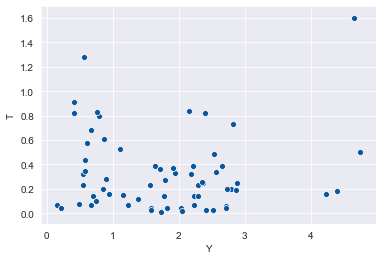

In [ ]:
fish_all.head()
sns.scatterplot(x='Y', y='T', data=fish_B)

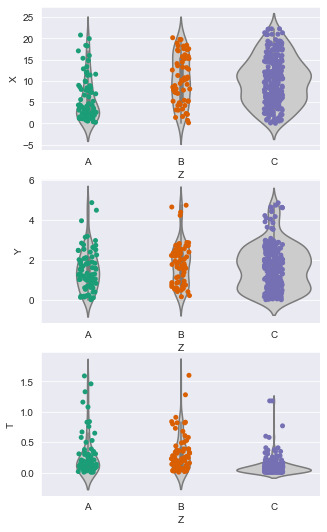

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(5,9))
sns.set_palette('Dark2')
sns.violinplot(x="Z", y="X", data=fish_all, scale='count',color=".8",ax=ax[0])
sns.stripplot(x="Z", y="X", data=fish_all,ax=ax[0])
sns.violinplot(x="Z", y="Y", data=fish_all, scale='count',color=".8",ax=ax[1])
sns.stripplot(x="Z", y="Y", data=fish_all,ax=ax[1])
sns.violinplot(x="Z", y="T", data=fish_all, scale='count',color=".8",ax=ax[2])
sns.stripplot(x="Z", y="T", data=fish_all,ax=ax[2])
plt.savefig('violinplot_of_X_Z_and_Y_Z.png')

9.4225

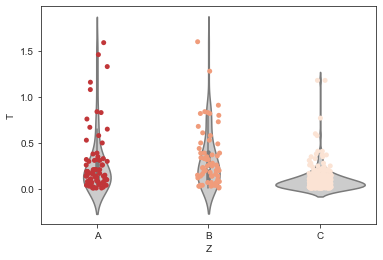

In [ ]:
sns.set_palette('RdBu')
ax = sns.violinplot(x="Z", y="T", data=fish_all, scale='count',color=".8")
ax = sns.stripplot(x="Z", y="T", data=fish_all)

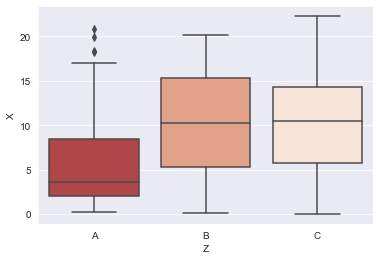

In [ ]:
sns.set_palette('RdBu')
sns.boxplot(x="Z", y="X", data=fish_all)

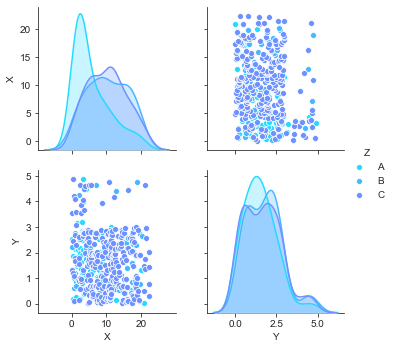

In [ ]:
sns.set_palette('cool')
sns.pairplot(fish_all.iloc[:,:3], hue="Z")